# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import pypyodbc as db

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
DRIVER_NAME = 'SQL Server'
SERVER_NAME = 'ACER-ANDI\ANDIMSQLSERVER'
DATABASE_NAME = 'ba_airways_db'

connection = db.connect('DRIVER={'+DRIVER_NAME+'};SERVER='+SERVER_NAME+';DATABASE='+DATABASE_NAME+';Trusted_Connection=yes;')
print(connection)

In [3]:
query = 'SELECT * FROM dbo.customer_booking'

df = pd.read_sql(query, connection)

df.head()

C:\Users\andid\AppData\Local\Temp\ipykernel_28036\2187257691.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [9]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

c:\Users\andid\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


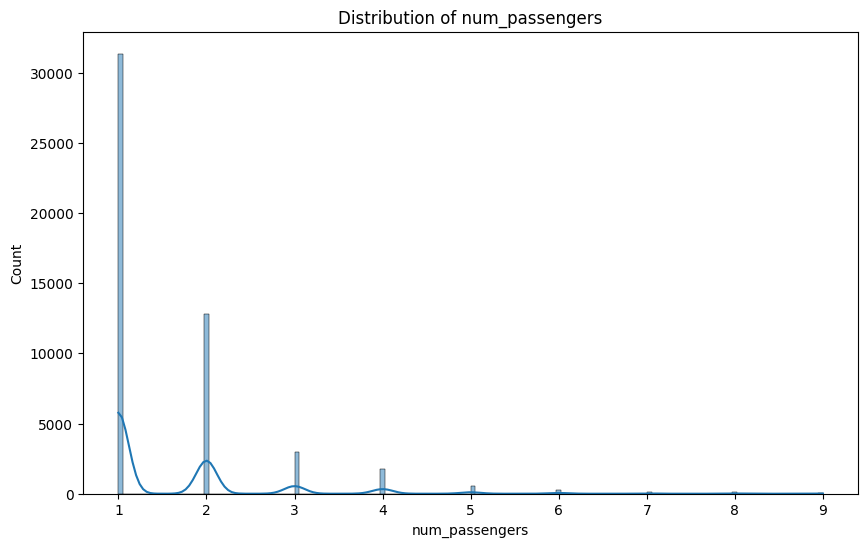

c:\Users\andid\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


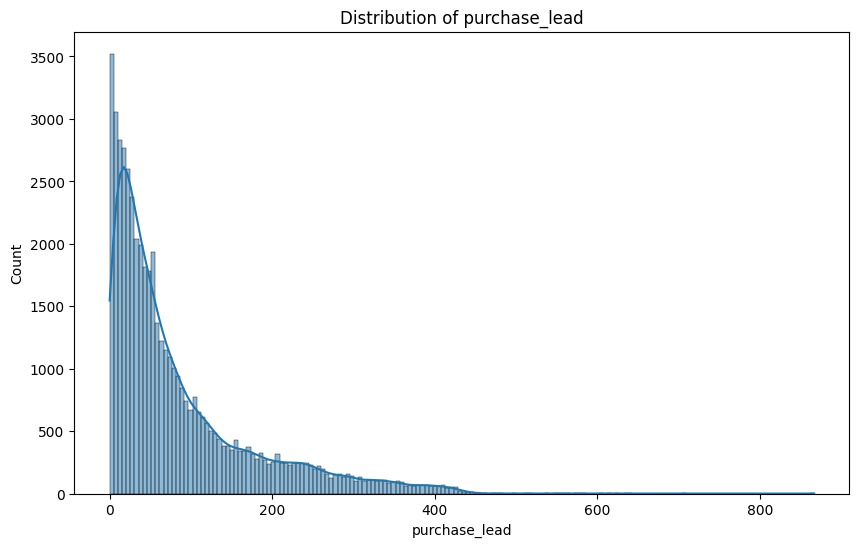

c:\Users\andid\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


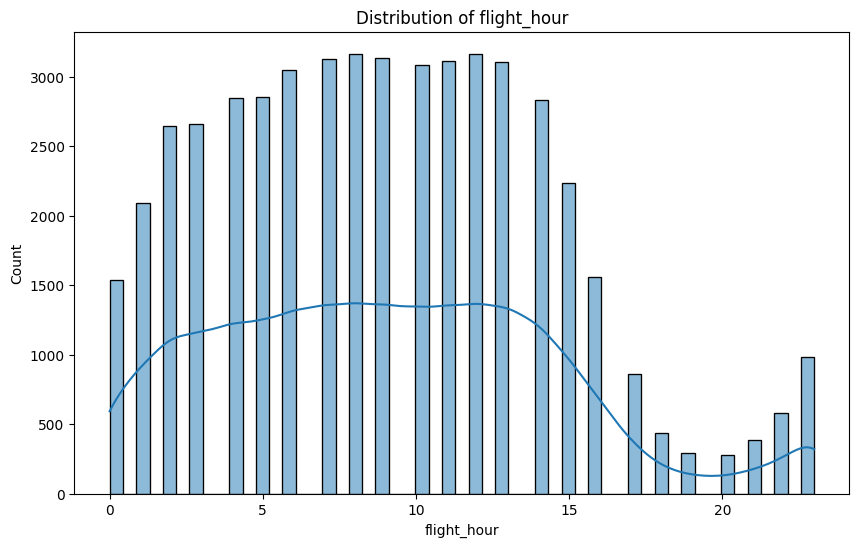

c:\Users\andid\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


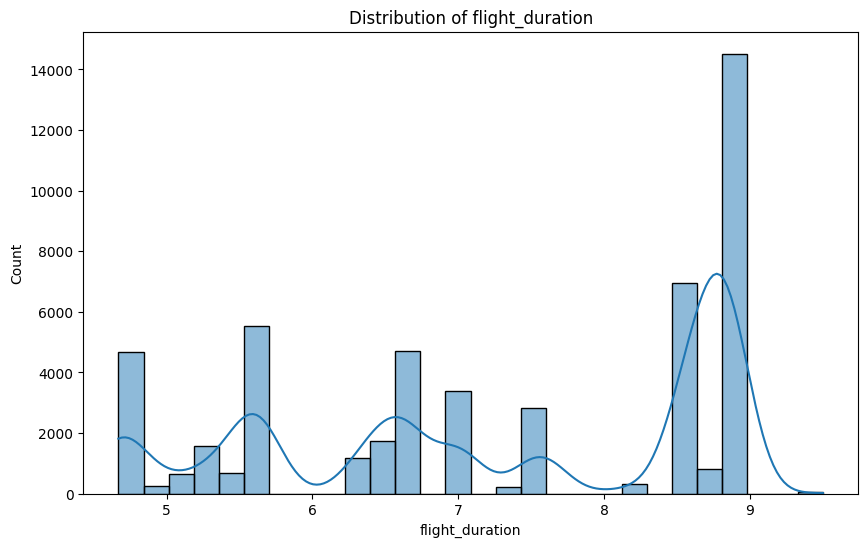

In [10]:
numerical_features = ['num_passengers', 'purchase_lead', 'flight_hour', 'flight_duration']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

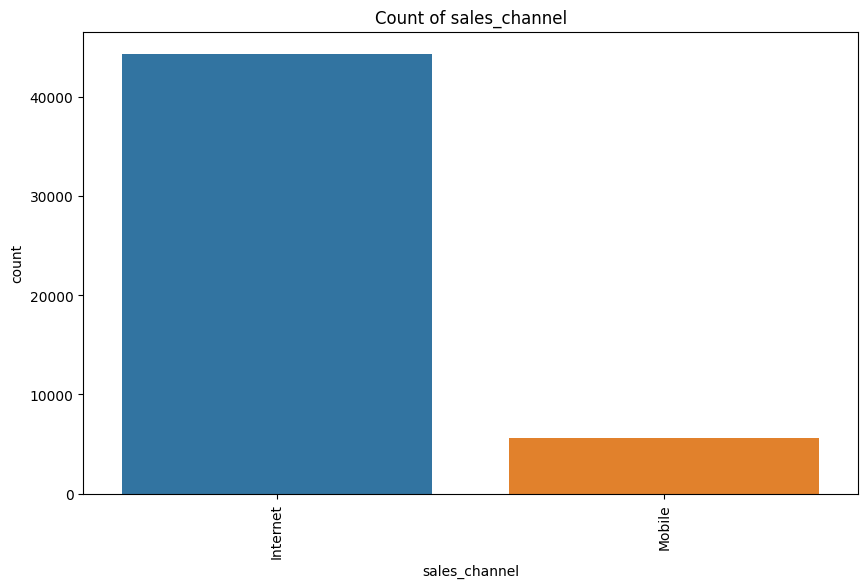

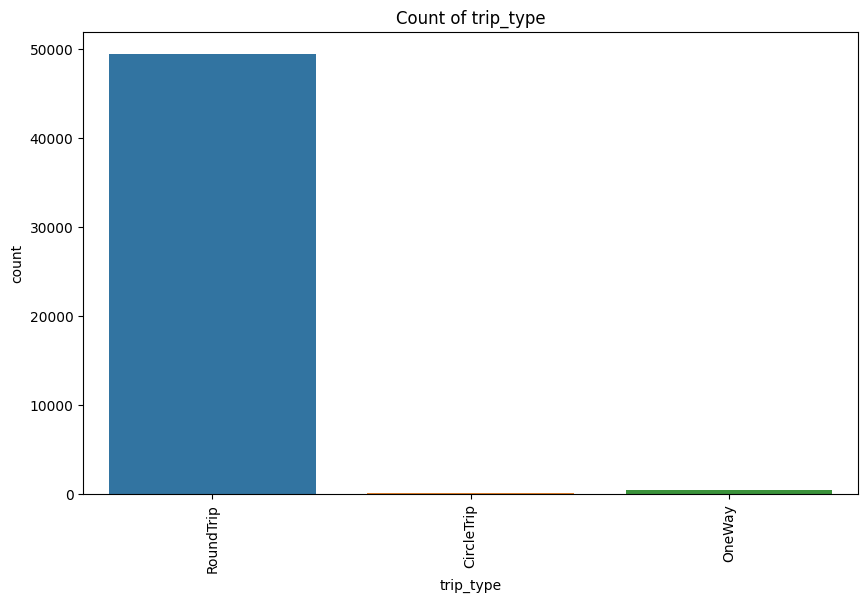

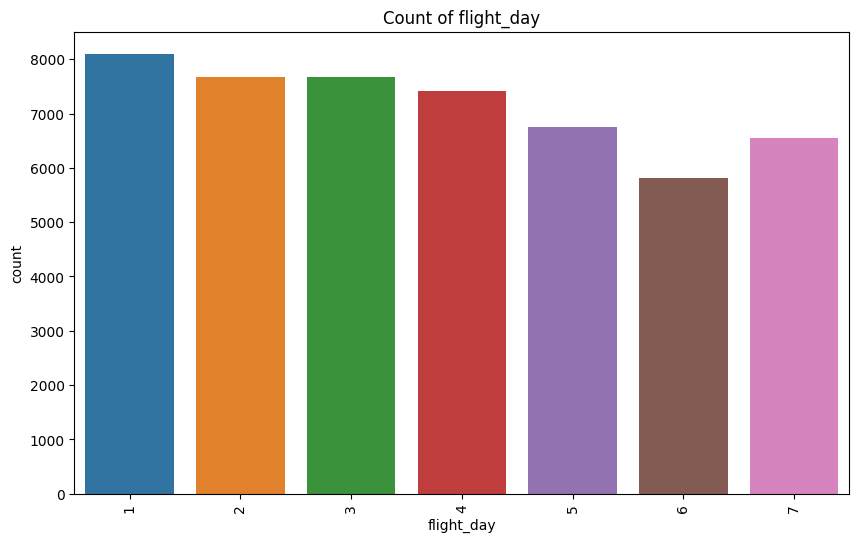

In [11]:
categorical_features = ['sales_channel', 'trip_type', 'flight_day']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df[feature])
    plt.title(f'Count of {feature}')
    plt.xticks(rotation=90)
    plt.show()

### Data Preprocessing

In [12]:
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

In [13]:
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [14]:
columns_to_drop = ['route', 'booking_origin']
existing_columns = [col for col in columns_to_drop if col in df.columns]
df = df.drop(existing_columns, axis=1)
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0.400684,0,2,1.957530,19,-0.381764,5,1,0,0,-1.174175,0
1,-0.579559,0,2,0.299164,20,-1.120780,5,0,0,0,-1.174175,0
2,0.400684,0,2,1.747470,22,1.465775,2,1,1,0,-1.174175,0
3,-0.579559,0,2,0.122272,31,-0.936026,5,0,0,1,-1.174175,0
4,0.400684,0,2,-0.187290,22,1.096267,2,1,0,1,-1.174175,0


### Predictive Modelling

In [15]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [17]:
y_pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

Accuracy: 0.8492
Precision: 0.4326923076923077
Recall: 0.060810810810810814
F1 Score: 0.1066350710900474
Confusion Matrix: [[8402  118]
 [1390   90]]


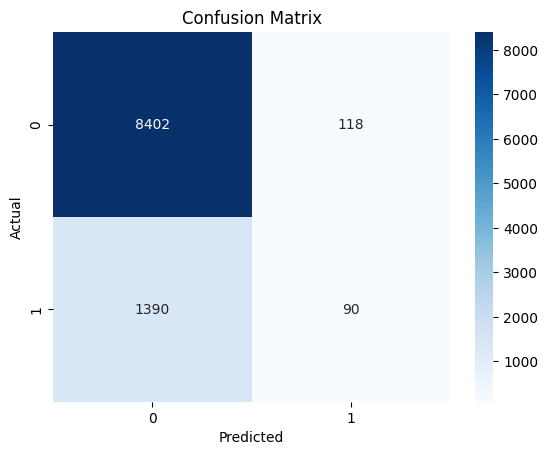

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

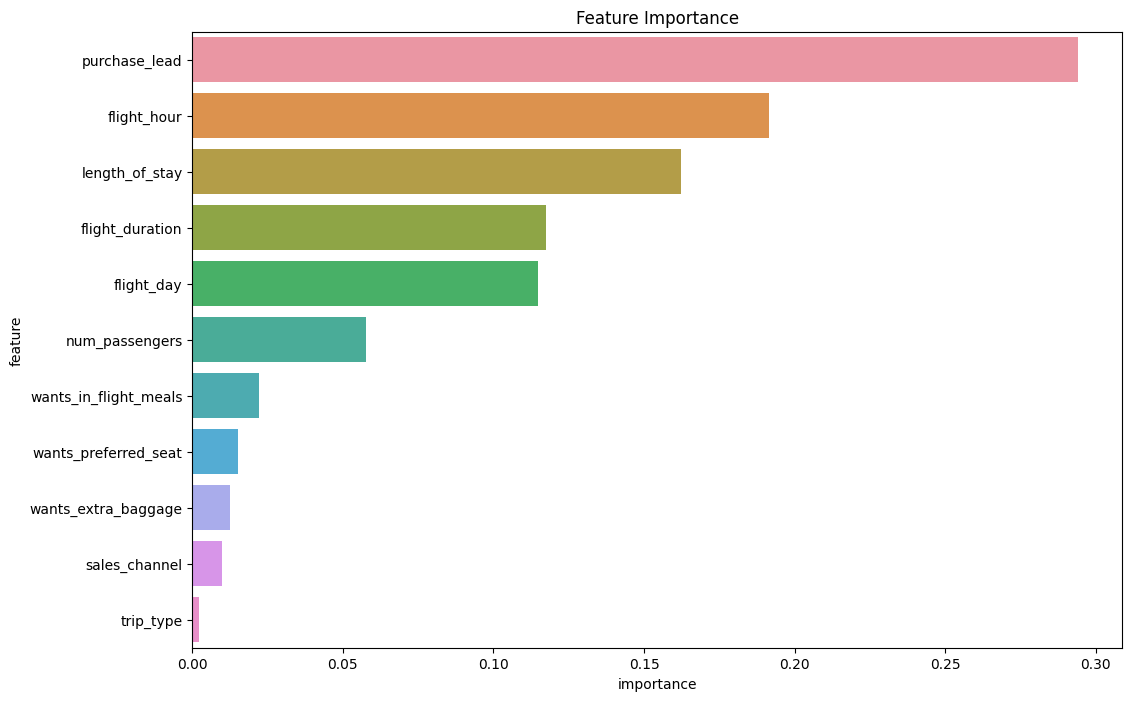

In [20]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

In [21]:
print('Feature Importance:', feature_importance)

Feature Importance:                   feature  importance
3           purchase_lead    0.294105
5             flight_hour    0.191389
4          length_of_stay    0.162375
10        flight_duration    0.117620
6              flight_day    0.114851
0          num_passengers    0.057780
9   wants_in_flight_meals    0.022003
8    wants_preferred_seat    0.015267
7     wants_extra_baggage    0.012396
1           sales_channel    0.009907
2               trip_type    0.002306


In [22]:
param_grid = {
	'n_estimators': [100, 200, 300],
	'max_depth': [10, 20, 30],
	'min_samples_split': [2, 5, 10],
	'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


RandomForestClassifier(max_depth=10, n_estimators=300)

In [23]:
y_pred = best_model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

Accuracy: 0.8524
Precision: 1.0
Recall: 0.002702702702702703
F1 Score: 0.005390835579514825
Confusion Matrix: [[8520    0]
 [1476    4]]


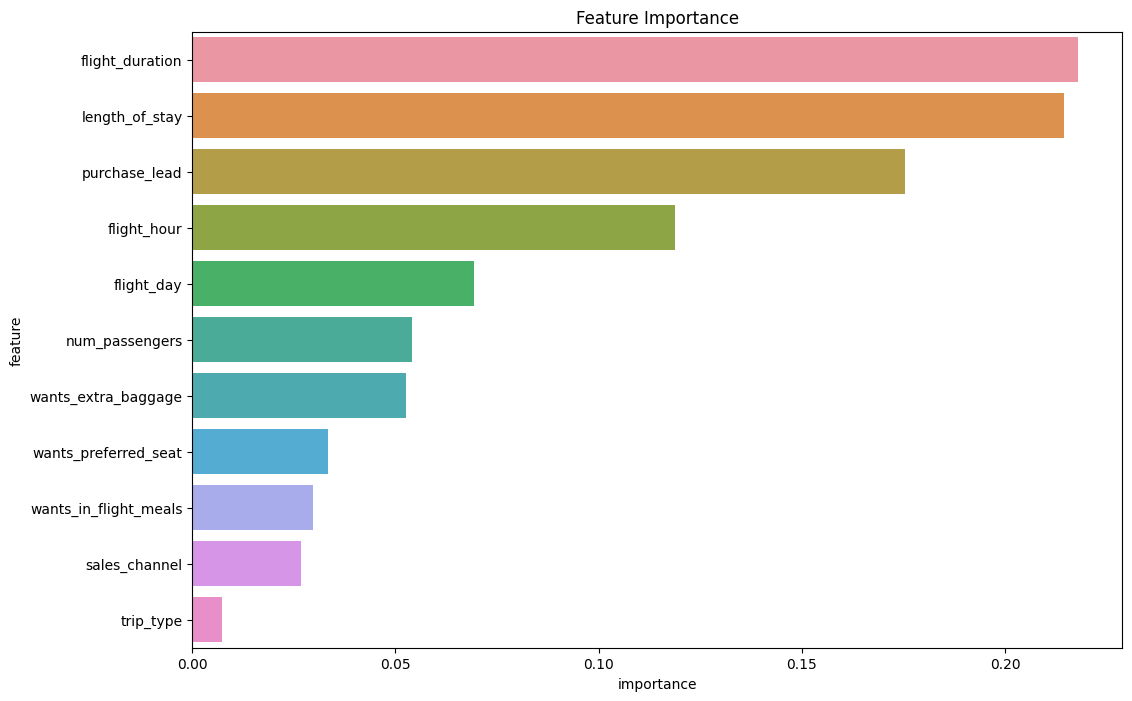

In [24]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

In [25]:
print('Feature Importance:', feature_importance)

Feature Importance:                   feature  importance
10        flight_duration    0.217943
4          length_of_stay    0.214608
3           purchase_lead    0.175462
5             flight_hour    0.118856
6              flight_day    0.069341
0          num_passengers    0.054131
7     wants_extra_baggage    0.052567
8    wants_preferred_seat    0.033409
9   wants_in_flight_meals    0.029765
1           sales_channel    0.026696
2               trip_type    0.007223
